In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
# Dataset && DataLoader
class HouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)  # Convert DataFrame to tensor
        self.y = torch.tensor(y.values, dtype=torch.long)  # Convert pd.Series to numpy.ndarray and then to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# PyTorch
class Net(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.15, l2_reg=0.00):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_prob)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(dropout_prob)

        self.fc5 = nn.Linear(32, output_size)

        self.l2_reg = l2_reg ## Adjust the value of l2_reg to find the suitable parameter
    # Function: Relu(), using 0.15 dropout in every layer to reduce fit
    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

    def l2_regularization(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2) ** 2
        return self.l2_reg * l2_loss

In [5]:
# Load the dataset
data = pd.read_csv('../data/Data_New.csv')

# Separate features and target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]  # Target variable

# Normalize features (except the second to last column)
scaler = MinMaxScaler()
X_normalized = X.iloc[:, :-1]  # Exclude the second to last column (L-3)
X_normalized = scaler.fit_transform(X_normalized)

# Add the PCA result column back to the normalized features
X_normalized = pd.DataFrame(X_normalized, columns=X.columns[:-1])
X_normalized["L-3"] = X.iloc[:, -2]  # Add the PCA result column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Create datasets and data loaders for training and testing sets
train_dataset = HouseDataset(X_train, y_train)
test_dataset = HouseDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the neural network model
input_size = X.shape[1]
output_size = 2  # Two classes: 0 or 1
model = Net(input_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels) + model.l2_regularization()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i + 1)}")

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# Save the model
torch.save(model.state_dict(), 'MLP_Model.pth')

Epoch 1/20, Loss: 0.2973788055613285
Epoch 2/20, Loss: 0.21822092770122167
Epoch 3/20, Loss: 0.21125311105270086
Epoch 4/20, Loss: 0.1986547572406258
Epoch 5/20, Loss: 0.19144907957456242
Epoch 6/20, Loss: 0.18976823222918773
Epoch 7/20, Loss: 0.1909441845858191
Epoch 8/20, Loss: 0.18167788802286772
Epoch 9/20, Loss: 0.1784181996123997
Epoch 10/20, Loss: 0.17322711552691272
Epoch 11/20, Loss: 0.17491240822893428
Epoch 12/20, Loss: 0.1705163045544324
Epoch 13/20, Loss: 0.16954891154850563
Epoch 14/20, Loss: 0.16924255819419237
Epoch 15/20, Loss: 0.1674073646505048
Epoch 16/20, Loss: 0.16676725986904986
Epoch 17/20, Loss: 0.1664542784313048
Epoch 18/20, Loss: 0.16469267911211713
Epoch 19/20, Loss: 0.1611526205431758
Epoch 20/20, Loss: 0.1568819915978458
Accuracy: 0.9540967423494571
Recall: 0.8134556574923547
Precision: 0.8926174496644296
F1 Score: 0.8512


[[8292  208]
 [ 293 1334]]


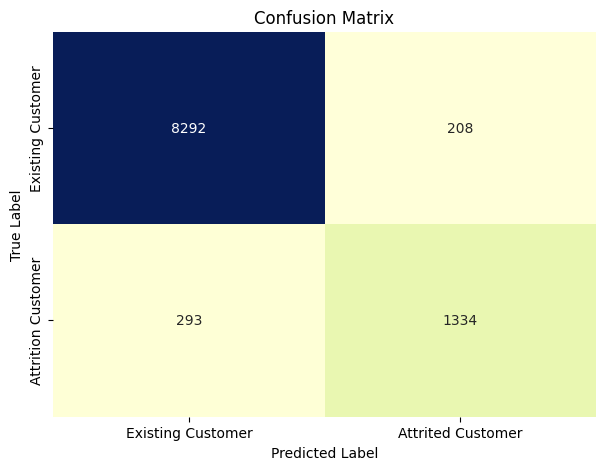

In [6]:
# Load the dataset
data = pd.read_csv('../data/Data_New.csv')

# Separate features and target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]  # Target variable

# Normalize features (except the second to last column)
scaler = MinMaxScaler()
X_all = X.iloc[:, :-1]  # Exclude the second to last column (L-3)
X_all = scaler.fit_transform(X_all)

# Add the PCA result column back to the normalized features
X_all = pd.DataFrame(X_all, columns=X.columns[:-1])
X_all["L-3"] = X.iloc[:, -2]  # Add the PCA result column

# Convert DataFrame to tensor
X_all = torch.tensor(X_all.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.int64)


# Load the saved model
model_loaded = Net(input_size=X_all.shape[1], output_size=2, dropout_prob=0.15, l2_reg=0.00)
model_loaded.load_state_dict(torch.load('MLP_Model.pth'))
model_loaded.eval()

# Make predictions on the whole dataset
with torch.no_grad():
    y_pred = model_loaded(X_all)
    _, predicted = torch.max(y_pred.data, 1)



from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y, predicted)
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", cbar=False, xticklabels=['Existing Customer', 'Attrited Customer'], yticklabels=['Existing Customer', 'Attrition Customer'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()